In [ ]:
%pip3 install opencv-python matplotlib

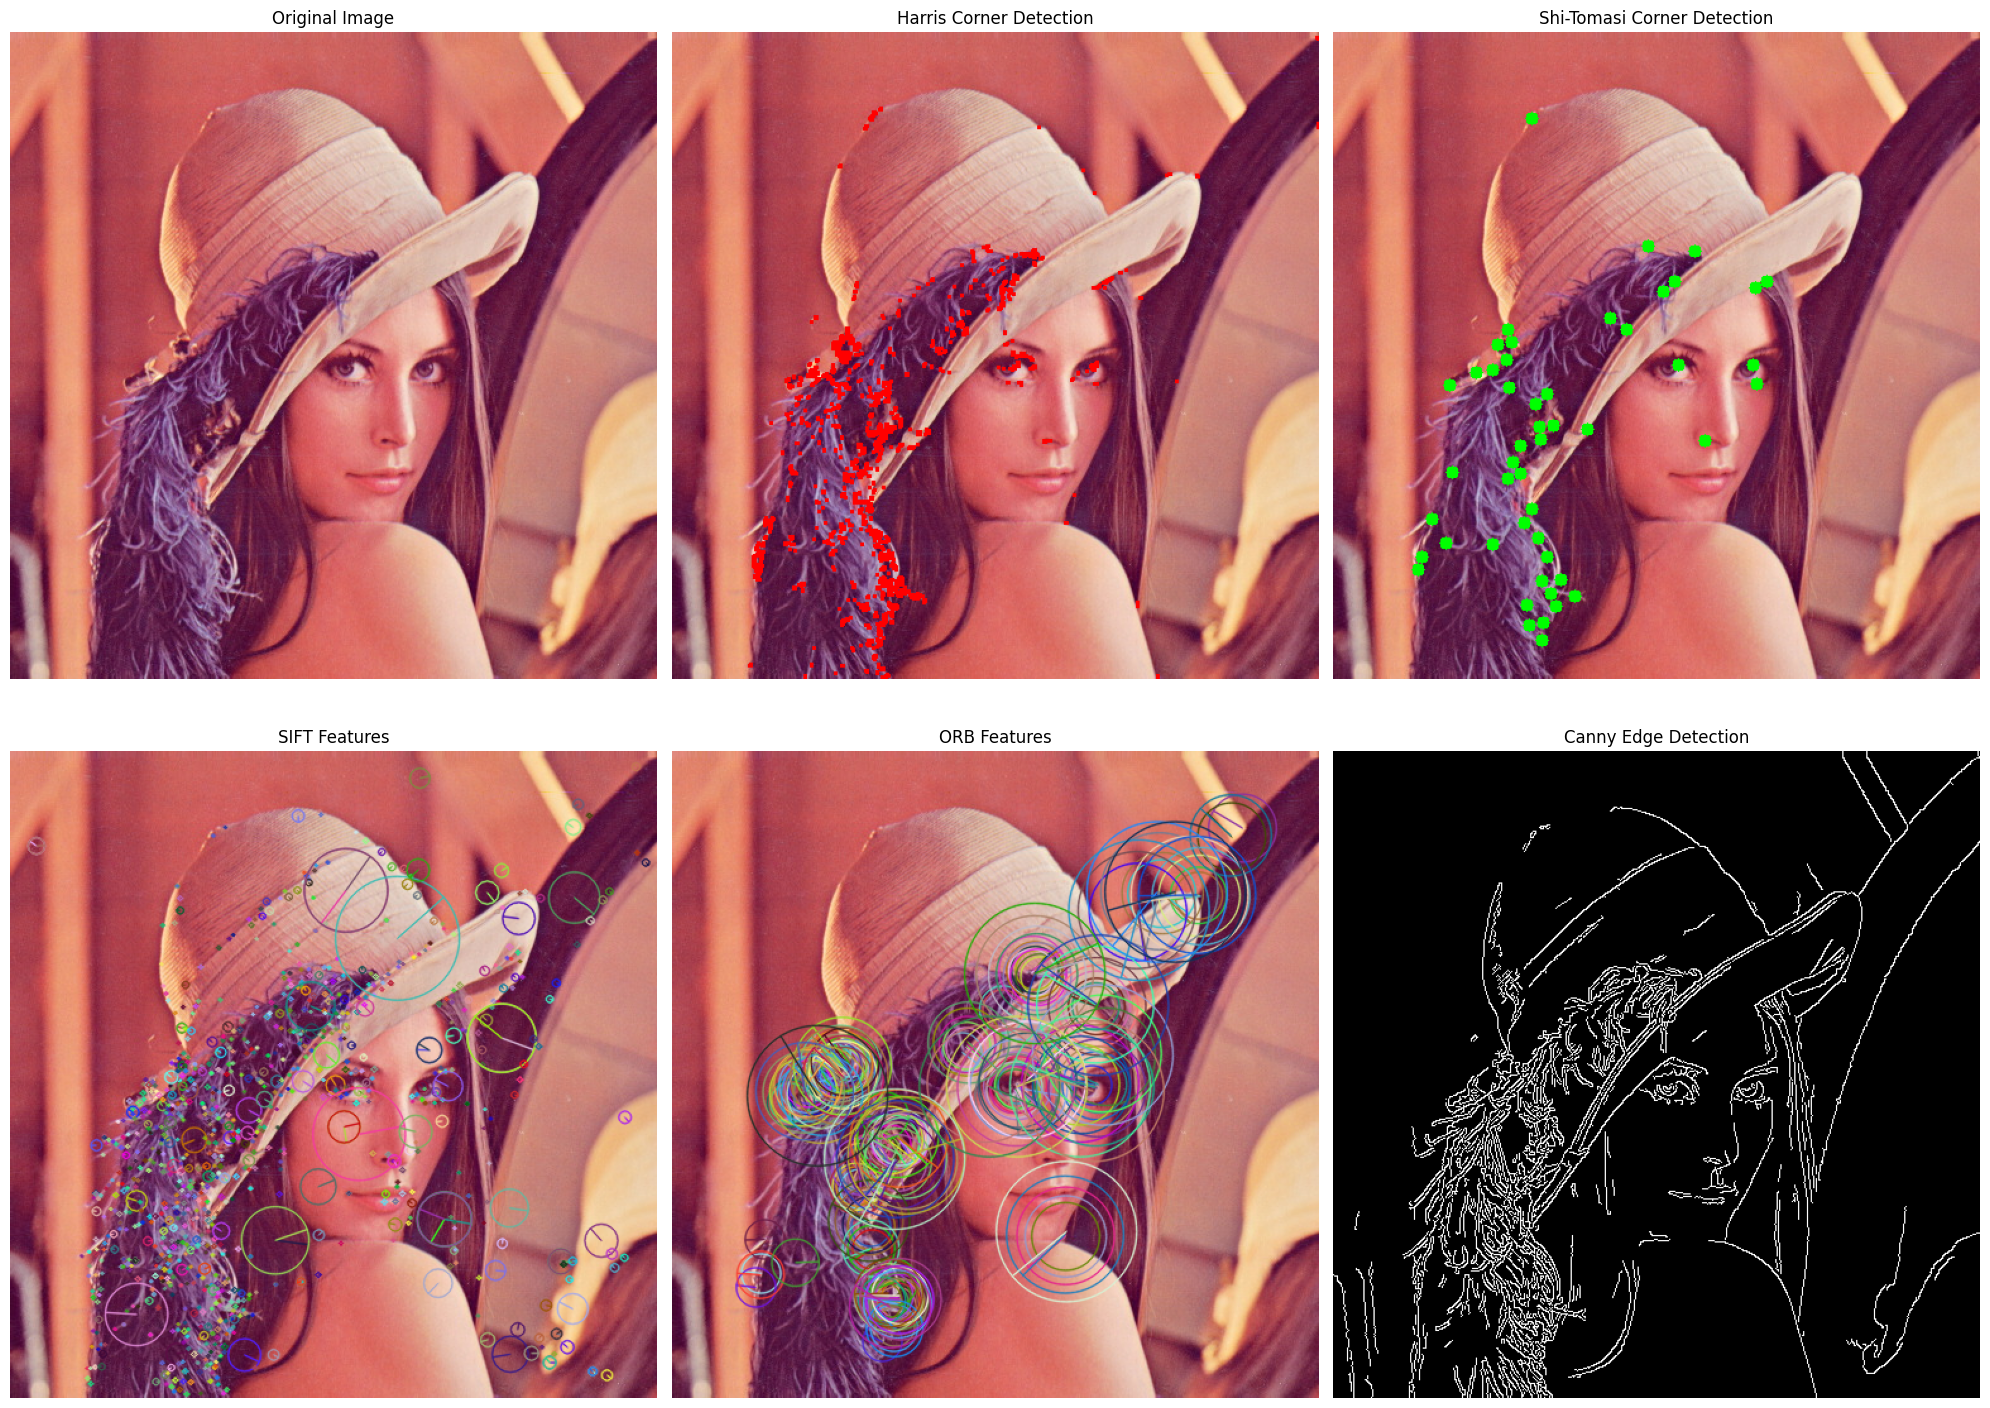

In [1]:
# Install OpenCV if needed
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import os

# Function to download and save an image if it doesn't exist
def get_sample_image(url, filename="sample_image.jpg"):
    with urlopen(url) as response:
        image_data = response.read()
    with open(filename, 'wb') as f:
        f.write(image_data)
    return filename

# Download a sample image
image_path = get_sample_image("https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg")

# Read the image
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Harris Corner Detection
gray_float = np.float32(gray)
corners = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)
# Dilate to mark the corners
corners = cv2.dilate(corners, None)
# Create a copy of the original image
img_harris = img.copy()
# Mark corners with red color (threshold for best corners)
img_harris[corners > 0.01 * corners.max()] = [0, 0, 255]

# 2. Shi-Tomasi Corner Detection
corners_st = cv2.goodFeaturesToTrack(gray, maxCorners=50, qualityLevel=0.01, minDistance=10)
img_shi_tomasi = img.copy()
# Draw circles around detected corners
if corners_st is not None:
    for corner in corners_st:
        x, y = corner.ravel()
        cv2.circle(img_shi_tomasi, (int(x), int(y)), 5, (0, 255, 0), -1)

# 3. SIFT (Scale-Invariant Feature Transform)
sift = cv2.SIFT_create()
keypoints_sift = sift.detect(gray, None)
img_sift = cv2.drawKeypoints(img, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 4. ORB (Oriented FAST and Rotated BRIEF)
orb = cv2.ORB_create(nfeatures=200)
keypoints_orb = orb.detect(gray, None)
img_orb = cv2.drawKeypoints(img, keypoints_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 5. Canny Edge Detection
edges = cv2.Canny(gray, 100, 200)

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_harris_rgb = cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB)
img_shi_tomasi_rgb = cv2.cvtColor(img_shi_tomasi, cv2.COLOR_BGR2RGB)
img_sift_rgb = cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB)
img_orb_rgb = cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img_harris_rgb)
plt.title('Harris Corner Detection')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(img_shi_tomasi_rgb)
plt.title('Shi-Tomasi Corner Detection')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img_sift_rgb)
plt.title('SIFT Features')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img_orb_rgb)
plt.title('ORB Features')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
!pip3 install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/23/rj3hwzds32x8m0hj4z25n9kh0000gn/T/pip-req-build-0a3ikx8z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/23/rj3hwzds32x8m0hj4z25n9kh0000gn/T/pip-req-build-0a3ikx8z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=13519936842abf00816b01eac247461fd98e6173da7ef0b372f5ef4273e39cb4
  Stored in directory: /private/var/folders/23/rj3hwzds32x8m0hj4z25n9kh0000gn/T/pip-ephem-wheel-cache-zbw9s0fx/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


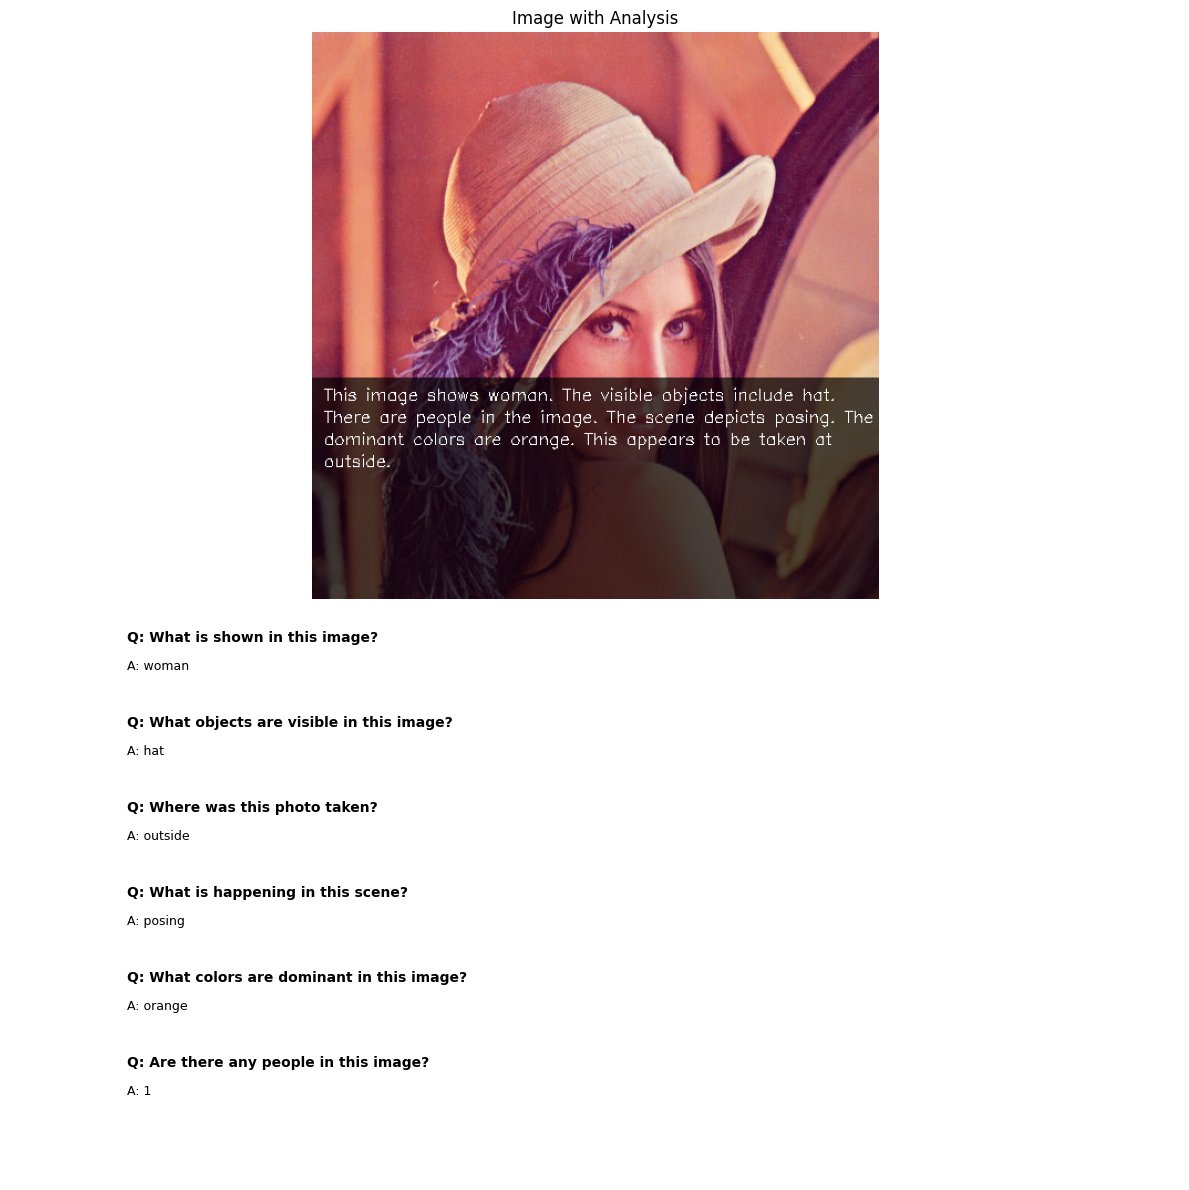

This image shows woman. The visible objects include hat. There are people in the image. The scene depicts posing. The dominant colors are orange. This appears to be taken at outside.


In [3]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import textwrap

def analyze_image_with_vqa(image_path):
    # Load model and processor
    processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
    model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Define questions to ask about the image
    questions = [
        "What is shown in this image?",
        "What objects are visible in this image?",
        "Where was this photo taken?",
        "What is happening in this scene?",
        "What colors are dominant in this image?",
        "Are there any people in this image?"
    ]
    
    results = {}
    
    # Process each question
    for question in questions:
        # Prepare inputs
        inputs = processor(image, question, return_tensors="pt")
        
        # Get model prediction
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Get the predicted answer
        idx = logits.argmax(-1).item()
        answer = model.config.id2label[idx]
        
        results[question] = answer
    
    # Create visualization
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Generate a comprehensive description from the answers
    description = f"This image shows {results['What is shown in this image?']}. "
    description += f"The visible objects include {results['What objects are visible in this image?']}. "
    
    if results['Are there any people in this image?'].lower() not in ['no', 'none', '0']:
        description += f"There are people in the image. "
        
    description += f"The scene depicts {results['What is happening in this scene?']}. "
    description += f"The dominant colors are {results['What colors are dominant in this image?']}. "
    
    if results['Where was this photo taken?'] not in ['unknown', 'not sure']:
        description += f"This appears to be taken at {results['Where was this photo taken?']}."
    
    # Create visual display
    img_annotated = img.copy()
    h, w = img_annotated.shape[:2]
    
    # Add overlay
    overlay = np.zeros((h, w, 3), dtype=np.uint8)
    overlay_height = min(h // 2, 200)  # Larger overlay for more text
    alpha = 0.7
    
    img_annotated[h-overlay_height:h, :] = cv2.addWeighted(
        img_annotated[h-overlay_height:h, :], 1-alpha, 
        overlay[h-overlay_height:h, :], alpha, 0
    )
    
    # Add description to image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    text_color = (255, 255, 255)
    
    # Wrap text
    wrapped_description = textwrap.wrap(description, width=60)
    
    y_pos = h - overlay_height + 20
    for line in wrapped_description:
        cv2.putText(img_annotated, line, (10, y_pos), font, font_scale, text_color, font_thickness)
        y_pos += 20
    
    # Display results
    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 1, 1)
    plt.imshow(img_annotated)
    plt.title('Image with Analysis')
    plt.axis('off')
    
    # Show raw QA results
    plt.subplot(2, 1, 2)
    plt.axis('off')
    y_pos = 0.95
    for question, answer in results.items():
        plt.text(0.1, y_pos, f"Q: {question}", fontsize=10, fontweight='bold')
        plt.text(0.1, y_pos-0.05, f"A: {answer}", fontsize=9)
        y_pos -= 0.15
    
    plt.tight_layout()
    plt.show()
    
    return description

# Install required package (only once)
# !pip install transformers pillow

result = analyze_image_with_vqa(image_path)
print(result)

In [ ]:
import cv2
import numpy as np
import time
import textwrap
import torch
from PIL import Image
from transformers import ViltProcessor, ViltForQuestionAnswering

# Load VQA model and processor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# Define questions to ask about each frame
questions = [
    "What is shown in this image?",
    "What objects are visible?",
    "What is happening in this scene?"
]

def process_frame_vqa(frame):
    """Process frame using VQA model to get detailed description"""
    # Convert OpenCV BGR to RGB and then to PIL Image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    results = {}
    
    # Process each question (limit to 3 for performance)
    for question in questions:
        # Prepare inputs
        inputs = processor(pil_image, question, return_tensors="pt")
        
        # Get model prediction
        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model(**inputs)
            logits = outputs.logits
        
        # Get the predicted answer
        idx = logits.argmax(-1).item()
        answer = model.config.id2label[idx]
        
        results[question] = answer
    
    # Generate a concise description from the answers
    description = f"This shows {results['What is shown in this image?']}. "
    description += f"Objects: {results['What objects are visible?']}. "
    description += f"Scene: {results['What is happening in this scene?']}."
    
    return results, description

def run_video_detection_vqa(source=0):
    # Initialize video capture source
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        print("Error: Could not open video source")
        return
    
    # Set frame size
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Process frames
    last_prediction_time = time.time()
    prediction_interval = 2.0  # VQA is more computationally intensive, so we process less frequently
    current_results = None
    current_description = None
    
    print("Starting video analysis. Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Make prediction at intervals
        current_time = time.time()
        if current_time - last_prediction_time > prediction_interval:
            # Update predictions
            current_results, current_description = process_frame_vqa(frame)
            last_prediction_time = current_time
            
        # Display results on frame
        if current_results is not None:
            # Add semi-transparent overlay at the bottom
            h, w = frame.shape[:2]
            overlay = np.zeros((h, w, 3), dtype=np.uint8)
            overlay_height = min(h // 3, 150)
            alpha = 0.7
            
            # Create a copy of frame to modify
            display_frame = frame.copy()
            
            # Apply overlay
            display_frame[h-overlay_height:h, :] = cv2.addWeighted(
                display_frame[h-overlay_height:h, :], 1-alpha,
                overlay[h-overlay_height:h, :], alpha, 0
            )
            
            # Add description text
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            text_color = (255, 255, 255)
            
            # Wrap text for better display
            wrapped_text = textwrap.wrap(current_description, width=60)
            
            y_pos = h - overlay_height + 20
            for line in wrapped_text:
                cv2.putText(display_frame, line, (10, y_pos), font, font_scale, text_color, font_thickness)
                y_pos += 20
                
            # Show individual Q&A results at the top
            y_pos = 30
            for question, answer in current_results.items():
                # Display in simplified format
                q_text = question.replace("What is shown in this image?", "Content:")
                q_text = q_text.replace("What objects are visible?", "Objects:")
                q_text = q_text.replace("What is happening in this scene?", "Action:")
                
                text = f"{q_text} {answer}"
                # Add black outline for visibility
                cv2.putText(display_frame, text, (10, y_pos), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3)  # Black outline
                cv2.putText(display_frame, text, (10, y_pos), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)  # White text
                y_pos += 25
        else:
            display_frame = frame.copy()
            cv2.putText(display_frame, "Analyzing scene...", (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            
        # Display the processed frame
        cv2.imshow('Real-time Scene Understanding', display_frame)
        
        # Exit on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Clean up
    cap.release()
    cv2.destroyAllWindows()

# Run with webcam
run_video_detection_vqa(0)

Starting video analysis. Press 'q' to quit.


: 